## Qubit Mover

The Qubit Mover is a reinforcement learning environment designed to optimize the movement of qubits in a quantum network. The goal is to maximize the quantum Fisher information (QFIM) by strategically moving qubits between nodes in the network. This is a first step towards developing a RL agent capable of creating arbitrary QNT protocols. 

The Network That will be simulated is a simple 4 node star network. Each channel on the network has a chance of flipping the qubit. This chance is determined by the network parameters ($\vec{\theta}$). The RL agent will be given a reward based on the QFIM of the final state after moving the qubits.

The QFIM of each distribution protocol is calcullated using the likelihood functions of the final states. This is done by symbolically summing the probability of even numbered bit flips for each qubit path. These values represent the eigenvalues of the density matrix, since we are only considering z basis measurements. The QFIM is then calculated by differentiating the eigenvalues with respect to the network parameters, hence the need for symbolic computation.

After the agent has been trained, the distribution protocol will benchmarked against previously determined QNT protocols for the same network. In addition a general estimator function will be created to evalueate the estimation accuracy of each protocol.

## Import Libraries
This section imports all the required libraries for quantum information calculations, symbolic computation, reinforcement learning, and plotting. Each library is chosen for its specific capabilities:
- `itertools`, `random`, `datetime`: Standard Python utilities for combinatorics, randomness, and time-stamping.
- `sympy`: Used for symbolic mathematics, which is essential for quantum Fisher information and protocol analysis.
- `numpy`: Efficient numerical operations and array handling.
- `matplotlib`: For visualizing results and protocol performance.
- `gymnasium`, `stable_baselines3`: RL environment and agent training.
- `scipy.optimize`: For numerical root finding and least squares estimation in parameter recovery.

In [1]:
# QFIM calculations libraries
from itertools import combinations
from sympy import symbols, prod, Add, Matrix, lambdify, solve, nonlinsolve

# Estimator libraries
from scipy.optimize import root, least_squares

# Standard libraries
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt

# RL libraries
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold



## Helper Functions
This section contains utility functions that support the main protocol logic. These helpers are used for combinatorial calculations, list manipulations, and symbolic construction of quantum likelihoods. They are essential for building the protocol paths, calculating probabilities, and preparing inputs for symbolic and numerical analysis.

#### Even Subsets
This function generates all even-length subsets of a given list. In the context of quantum protocols, it is used to enumerate all possible combinations of channels where an even number of bit flips can occur. This is crucial for calculating the likelihoods of measurement outcomes in the z-basis, as only even flips contribute to certain eigenvalues of the density matrix.

In [2]:
def even_subsets(input_list):
    subsets = []
    for r in range(0, len(input_list) + 1, 2):  # Only even lengths: 0, 2, 4, ...
        subsets.extend(combinations(input_list, r))
    return [list(subset) for subset in subsets]


subsets=(even_subsets([1, 2, 3]))
print(subsets)

[[], [1, 2], [1, 3], [2, 3]]


In [3]:

def list_subtract(a, b):
    result = a.copy()
    for item in b:
        if item in result:
            result.remove(item)
    return result


print(list_subtract([1, 2, 3], [1, 2]))     # Output: [3]
print(list_subtract([1, 2, 2], [2]))        # Output: [1, 2]


[3]
[1, 2]


### Define Parameters as symbols
This section sets up symbolic variables for the protocol parameters (thetas and their complements). Symbolic computation allows for analytical manipulation of the protocol equations, enabling differentiation, substitution, and equation solving. This is essential for quantum Fisher information calculations and for constructing estimators that can recover protocol parameters from measurement data.

In [4]:
def symbolic_sum_of_products(full_set):
    subsets = even_subsets(full_set)
    symbols_list = symbols('p1 p2 p3')
    hat_symbols_list = symbols('p1_hat p2_hat p3_hat')

    terms = []
    for subset in subsets:
        if subset:  # skip empty subsets
            terms_list = [symbols_list[i - 1] for i in subset]
            remainder = list_subtract(full_set, subset)
            if remainder:
                terms_list += [hat_symbols_list[i - 1] for i in remainder]
            term = prod(terms_list)
            terms.append(term)
        else:
            # For the empty subset, use all hat symbols
            remainder = list_subtract(full_set, subset)
            term=prod([hat_symbols_list[i - 1] for i in remainder])
            terms.append(term)
    return Add(*terms)

# Example usage:
print(symbolic_sum_of_products([1, 2, 3,2]))


p1*p2**2*p3 + 2*p1*p2*p2_hat*p3_hat + p1*p2_hat**2*p3 + p1_hat*p2**2*p3_hat + 2*p1_hat*p2*p2_hat*p3 + p1_hat*p2_hat**2*p3_hat


### Convert the equations into eigenvalues
This section describes how the protocol equations are mapped to the eigenvalues of the quantum state's density matrix. Each eigenvalue corresponds to a specific measurement outcome (bit flip pattern). Calculating these eigenvalues is necessary for evaluating the quantum Fisher information and for simulating measurement statistics.

In [5]:
def equations_to_eigen_vals(expressions):
    e1,e2,e3=expressions

    element_1=e1*e2*e3 # No bits flip

    element_2=e1*e2*(1-e3) # Bit 3 flips

    element_3=e1*(1-e2)*e3 # Bit 2 flips

    element_4=e1*(1-e2)*(1-e3) # Bits 2 and 3 flip

    element_5=(1-e1)*e2*e3 # Bit 1 flips

    element_6=(1-e1)*e2*(1-e3) # Bits 1 and 3 flip

    element_7=(1-e1)*(1-e2)*e3 # Bits 1 and 2 flip

    element_8=(1-e1)*(1-e2)*(1-e3) # Bits 1, 2, and 3 flip

    eigen_vals = [
        element_1, element_2, element_3, element_4,
        element_5, element_6, element_7, element_8
    ]

    return eigen_vals


In [6]:
e1=symbolic_sum_of_products([1, 2,3])
e2=symbolic_sum_of_products([1, 2,3])
e3=symbolic_sum_of_products([1, 2,3])

eigen_vals=equations_to_eigen_vals([e1,e2,e3])

for expression in eigen_vals:

    print(expression)
    print("-----")

(p1*p2*p3_hat + p1*p2_hat*p3 + p1_hat*p2*p3 + p1_hat*p2_hat*p3_hat)**3
-----
(p1*p2*p3_hat + p1*p2_hat*p3 + p1_hat*p2*p3 + p1_hat*p2_hat*p3_hat)**2*(-p1*p2*p3_hat - p1*p2_hat*p3 - p1_hat*p2*p3 - p1_hat*p2_hat*p3_hat + 1)
-----
(p1*p2*p3_hat + p1*p2_hat*p3 + p1_hat*p2*p3 + p1_hat*p2_hat*p3_hat)**2*(-p1*p2*p3_hat - p1*p2_hat*p3 - p1_hat*p2*p3 - p1_hat*p2_hat*p3_hat + 1)
-----
(p1*p2*p3_hat + p1*p2_hat*p3 + p1_hat*p2*p3 + p1_hat*p2_hat*p3_hat)*(-p1*p2*p3_hat - p1*p2_hat*p3 - p1_hat*p2*p3 - p1_hat*p2_hat*p3_hat + 1)**2
-----
(p1*p2*p3_hat + p1*p2_hat*p3 + p1_hat*p2*p3 + p1_hat*p2_hat*p3_hat)**2*(-p1*p2*p3_hat - p1*p2_hat*p3 - p1_hat*p2*p3 - p1_hat*p2_hat*p3_hat + 1)
-----
(p1*p2*p3_hat + p1*p2_hat*p3 + p1_hat*p2*p3 + p1_hat*p2_hat*p3_hat)*(-p1*p2*p3_hat - p1*p2_hat*p3 - p1_hat*p2*p3 - p1_hat*p2_hat*p3_hat + 1)**2
-----
(p1*p2*p3_hat + p1*p2_hat*p3 + p1_hat*p2*p3 + p1_hat*p2_hat*p3_hat)*(-p1*p2*p3_hat - p1*p2_hat*p3 - p1_hat*p2*p3 - p1_hat*p2_hat*p3_hat + 1)**2
-----
(-p1*p2*p3_hat - p1*p2_

### Calculate the QFIM
This section details the calculation of the quantum Fisher information matrix (QFIM) from the protocol's eigenvalues. The QFIM quantifies the sensitivity of the quantum state to changes in the protocol parameters (thetas). It is a key metric for benchmarking protocols and serves as the reward signal for the RL agent, guiding it to maximize information extraction.

In [7]:
def quantum_fisher_information(lambdas,thetas):

    symbols_list = symbols('p1 p2 p3')
    p1_hat, p2_hat, p3_hat = symbols('p1_hat p2_hat p3_hat')
    p1, p2, p3 = symbols_list        

    n = len(symbols_list)
    F = Matrix.zeros(n, n)

    subs_dict = {symbols('p1_hat'): 1 - symbols('p1'),
                 symbols('p2_hat'): 1 - symbols('p2'),
                 symbols('p3_hat'): 1 - symbols('p3')}
    lambdas_sub = [lam.subs(subs_dict) for lam in lambdas]

    for i in range(n):
        for j in range(n):
            s = 0
            for lam in lambdas_sub:
                if lam == 0:
                    continue  # Skip zero eigenvalues
                s += (1/lam) * lam.diff(symbols_list[i]) * lam.diff(symbols_list[j])
            F[i, j] = s

    number_F=F.subs({
        p1: thetas[0],
        p2: thetas[1],
        p3: thetas[2]
    })
    return number_F

In [8]:
e1=symbolic_sum_of_products([1, 2,3])
e2=symbolic_sum_of_products([1, 2,3])
e3=symbolic_sum_of_products([1, 2,3])

eigen_vals=equations_to_eigen_vals([e1,e2,e3])


F=quantum_fisher_information(eigen_vals,[0.1,0.2,0.3])
print(F)
trace_F = F.trace()
print(trace_F)

Matrix([[0.717655658183268, 0.956874210911024, 1.43531131636654], [0.956874210911024, 1.27583228121470, 1.91374842182205], [1.43531131636654, 1.91374842182205, 2.87062263273307]])
4.86411057213104


### Create a function that maps nodes to paths
This section provides a function to convert a list of node actions into a path representation for each qubit. This mapping is necessary to simulate the movement of qubits through the network, track their history, and correctly compute the likelihoods and rewards for each protocol. This function essentially translates the agent's actions into actual effects in the training enviornment.

In [9]:
def nodes_to_paths(node_list):
    path_list=[]
    path_list.append(node_list[0])

    if len(node_list)==1: # Ensures that single node lists are handled correctly
        print("ERROR: Single node list detected")
        return path_list

    for i in range(1,len(node_list)):
        path_list.append(node_list[i])
        path_list.append(node_list[i])

    filtered_list = [x for x in path_list if x != 0]
    filtered_list.pop()

    return filtered_list

### Create the reward function
This section defines the reward function for the RL agent. The reward is based on the quantum Fisher information, which measures the protocol's effectiveness in extracting information about the network parameters. The function also validates protocol structure and penalizes invalid actions, ensuring the agent learns meaningful strategies.

The reward function is crucial for guiding the RL agent's learning process, as it provides feedback on the quality of the protocols generated. By maximizing the QFIM, the agent is incentivized to discover optimal qubit movement strategies that enhance parameter estimation in the quantum network.

This function encodes the rules of the game as well as the desired outcome (maximizing QFIM) into a form that the RL algorithm can use to update its policy.

In [10]:
def reward(node_lists,thetas):

    #################################
    ## Make sure the protocol is valid
    #################################

    # Make sure that the first element is not 0 and the last element is 0
    for node_list in node_lists:
        if node_list[0]==0 or node_list[1]==0 or node_list[-1]!=0:
            #print("Yikes")
            return -10 # Large negative reward for invalid input
        found_zero = False
        for val in node_list:
            if val == 0:
                found_zero = True
            elif found_zero and val != 0:
                #print("Invalid: nonzero after zero")
                return -10  # or any large negative reward

    ################################
    ## Calculate the QFIM
    #################################
    
    path_lists=[]
    for node_list in node_lists:
        path_list=nodes_to_paths(node_list)
        path_lists.append(path_list)

    e1=symbolic_sum_of_products(path_lists[0])
    e2=symbolic_sum_of_products(path_lists[1])
    e3=symbolic_sum_of_products(path_lists[2])

    eigen_vals=equations_to_eigen_vals([e1,e2,e3])
    F=quantum_fisher_information(eigen_vals,thetas)

    try:
        F_inv = F.inv()
        qcrb= F_inv.trace()

        max_qcrb = 1000.0

        
        reward_val=1-qcrb/max_qcrb # Higher reward for lower qcrb, normalized between 0 and 1
        reward_val = np.clip(reward_val, 0, 1)  # Ensure reward is within [0, 1]

        
    except Exception as e:
        # If F is singular or not invertible, give a large negative reward
        reward_val = -10

    return reward_val


In [ ]:
# Testing valid moves and their rewards
q1=[3,2,2,0,0,0]
q2=[3,3,2,0,0,0]
q3=[3,3,1,0,0,0]


print(reward([q1,q2,q3],[0.1,0.2,0.3]))

0.792479455814231


## RL Agent Implementation
This section introduces the reinforcement learning (RL) agent and environment. RL is used to discover optimal qubit movement protocols that maximize quantum Fisher information. The environment simulates the network, and the agent learns to select actions that improve protocol performance through trial and error, guided by the reward function.

The RL agent is implemented using the Stable Baselines3 library. The environment is defined using the OpenAI Gymnasium interface, and the agent is trained using the Proximal Policy Optimization (PPO) algorithm.

The action space consists of 4 x 3 matrix, the columns represent the qubits being moved, and the rows represent the nodes they are being moved to. The agent can choose to move a qubit to any of the other 3 nodes, or choose to measure it (represented by a 0). The agent will be able to choose 10 steps for each qubit, after which the final state will be measured and the reward will be given based on the QFIM of the final state. Each distribution protocol must start by initializing the qubits at a source node and end by measuring them.

The reward function is defined as the trace of the QFIM, which is a measure of the total information about the parameters that can be extracted from the quantum state. The agent is trained to maximize this reward by learning to move the qubits in a way that maximizes the QFIM, for a given set of thetas.

### Create RL agent environment
This section defines the custom RL environment for the Qubit Mover agent. The environment models the network, qubit states, and protocol actions, providing a realistic simulation for agent training. It ensures the agent interacts with the protocol in a way that reflects the constraints and goals of quantum network optimization.

for help understanding the syntax and structure of the gymnasium environment, refer to the official documentation: https://gymnasium.farama.org/

In [12]:
class QubitMoverEnv(gym.Env):
    """
    Custom Environment for the Qubit Mover RL agent.
    - 3 qubits, each with a path of length 10
    - Each step, the agent selects a node (1-3) or 0 (measure) for each qubit
    - Episode ends after a fixed number of steps or when all qubits are measured
    """
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self):
        super().__init__()
        self.n_qubits = 3
        self.max_steps = 10
        self.thetas = np.random.uniform(0.05, 0.5, 3).tolist()

        # Each qubit can be at node 0, 1, 2, or 3 at each step
        self.action_space = spaces.MultiDiscrete([4] * self.n_qubits)


        # Observation space: qubit states + theta values
        # Qubit states: (n_qubits * max_steps), Theta: (3,)
        low = np.zeros(self.n_qubits * self.max_steps + 3)
        high = np.concatenate([np.full(self.n_qubits * self.max_steps, 3), np.ones(3)])
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.thetas = np.random.uniform(0.05, 0.5, 3).tolist() 
        self.state = np.zeros((self.n_qubits, self.max_steps), dtype=np.int32)
        self.state=self.state.flatten()
        self.current_step = 0
        self.done = False
        obs = np.concatenate([self.state, np.array(self.thetas, dtype=np.float32)]).astype(np.float32)
        return obs, {}


    def step(self, action):
        # action: array of length 3, each in {0,1,2,3}
        if self.done:
            raise RuntimeError("Episode is done")

        # Record the action for each qubit at this step
        # Update the observation space
        for q in range(self.n_qubits):
            self.state[q * self.max_steps + self.current_step] = action[q]

        self.current_step += 1

        # If all qubits have been measured (0) or max_steps reached, episode is done
        state_2d = self.state.reshape(self.n_qubits, self.max_steps)
        all_measured = np.all(state_2d[:, self.current_step-1] == 0)

        self.done = all_measured or self.current_step >= self.max_steps

        reward_val = 0
        
        # The reward is only calculated at the end of the episode
        if self.done:
            # Convert state to list of lists for your reward function
            node_lists = [list(state_2d[q]) for q in range(self.n_qubits)]
            reward_val = reward(node_lists, self.thetas)
        else:
            reward_val = 0  # Or a step penalty if desired

        self.state=self.state.flatten()
        obs = np.concatenate([self.state, np.array(self.thetas, dtype=np.float32)]).astype(np.float32)

        return obs.copy(), reward_val, self.done, False, {}

    def render(self):
        print("Step:", self.current_step)
        print("State:\n", self.state)

    def close(self):
        pass

# Example usage:
# env = QubitMoverEnv()
# obs, info = env.reset()
# done = False
# while not done:
#     action = env.action_space.sample()
#     obs, reward, done, truncated, info = env.step(action)
#     env.render()

#### Check if the environment works
This section uses Stable Baselines3's environment checker to validate that the custom RL environment adheres to the Gymnasium API. This step is crucial for ensuring compatibility with RL algorithms and preventing runtime errors during agent training.

In [13]:
from stable_baselines3.common.env_checker import check_env

# Instantiate the environment
env = QubitMoverEnv()

# Check if the environment follows the Gymnasium API and is compatible with Stable Baselines3
check_env(env, warn=True)

print("Environment check passed!")

Environment check passed!


/Users/noahplant/Library/Python/3.9/lib/python/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/noahplant/Library/Python/3.9/lib/python/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


### Create the RL agent
This section creates the RL agent using the Proximal Policy Optimization (PPO) algorithm. PPO is chosen for its stability and effectiveness in continuous and discrete action spaces. The agent is trained to optimize qubit movement protocols, learning strategies that maximize the quantum Fisher information reward.

In [17]:
# Create and train the RL agent using PPO

# Instantiate the environment
env = QubitMoverEnv()

# Create the PPO agent
model = PPO(
    "MlpPolicy",      # Use a multilayer perceptron policy
    env,              # Pass your custom environment
    verbose=1,        # Print training progress
    tensorboard_log="./ppo_qubit_mover_tensorboard/"  # Optional: log for TensorBoard
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


### Train the agent
This section describes the training process for the RL agent. Evaluation callbacks are used to monitor performance and save the best models. Training involves running many episodes, allowing the agent to explore different protocols and learn from the reward feedback.

The actual training was done on monsoon as it requires a fair amount of time. However the code cell below provides a mostly accurate representation of the training process used.

In [ ]:
# Initialize evaluation callback
# Create a callback that stops training when mean reward > threshold

# Evaluate every 1000 steps, use stop_callback to halt training
eval_callback = EvalCallback(
    env,
    eval_freq=1000,
    best_model_save_path='/best_model/',
    verbose=1
)


# Train the agent
model.learn(total_timesteps=50_000)  # You can increase timesteps for better training



timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the trained model
model.save(f"agents/ppo_qubit_mover_agent_{timestamp}")


# To load and use the agent later:
# model = PPO.load("ppo_qubit_mover_agent", env=env)

### Continue training if needed
This section provides instructions for resuming agent training from a saved model. Continuing training allows the agent to further refine its protocol strategies, adapt to new environments, or recover from suboptimal initial learning.

In [ ]:
# Instantiate your environment
env = QubitMoverEnv()

# Load the previously trained model
model = PPO.load("agents/ppo_qubit_mover_agent_20250902_142832.zip", env=env)

# Continue training for more timesteps (epochs)
model.learn(total_timesteps=50_000)  # Change this number as needed

# Optionally, save the model again after further training
model.save("agents/ppo_qubit_mover_agent_continued")

#### View Training Logs
This section shows how to launch TensorBoard to visualize RL training metrics. TensorBoard provides insights into agent performance, reward trends, and training stability, helping diagnose issues and track progress.

In [1]:
! tensorboard --logdir ./ppo_qubit_mover_tensorboard/ --host=localhost --port=6006

TensorBoard 2.18.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


### Evaluate the trained agent
This section describes how to evaluate the trained RL agent on a test protocol. Evaluation measures the agent's ability to generalize and optimize protocols for different parameter values, providing benchmarks for protocol performance.

In [ ]:
# Load the trained agent (update timestamp as needed)
model = PPO.load("agents/ppo_qubit_mover_agent_continued.zip", env=env)

# Evaluate the agent for one episode
obs, info = env.reset()

# Custom observation for testing

obs, info = env.reset()
env.thetas=[0.4, 0.4,  0.4]

done = False
total_reward = 0

while not done:
    action, _states = model.predict(obs, deterministic=False)
    obs, reward_vals, done, truncated, info = env.step(action)
    total_reward += reward_vals
    env.render()

print(f"Total episode reward: {total_reward}")
print("Final thetas used:", env.thetas)
print(obs)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step: 1
State:
 [3 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
Step: 2
State:
 [3 3 0 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0]
Step: 3
State:
 [3 3 3 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0]
Step: 4
State:
 [3 3 3 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0]
Total episode reward: 0.503919999999989
Final thetas used: [0.4, 0.4, 0.4]
[3.  3.  3.  0.  0.  0.  0.  0.  0.  0.  3.  1.  0.  0.  0.  0.  0.  0.
 0.  0.  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.4 0.4 0.4]
Step: 1
State:
 [3 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
Step: 2
State:
 [3 3 0 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0]
Step: 3
State:
 [3 3 3 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0]
Step: 4
State:
 [3 3 3 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0]
Total episode reward: 0.503919999999989
Final thetas used: [0.4, 0.4, 0.4]
[3.  3.  3.  0.

## Benchmark RLA Against Fixed Protocols
This section benchmarks the RL agent's learned protocols against fixed, analytically derived strategies. Comparing QCRB values across protocols helps quantify the agent's performance and identify cases where learning provides an advantage over traditional approaches.

Here the math matical reasoning behind the QFIM calculations was done in a mathematica notebook. The results were then imported into this notebook for comparison against the RL agent's learned protocols.

### RLA QCRB
This section implements the RLA protocol, another fixed strategy for qubit distribution. Its QCRB is calculated and compared to the RL agent and other protocols to assess relative performance.

In [14]:
def eval_model_monsoon(thetas):

    model = PPO.load("agents/monsoon2.zip", env=env)

    # Evaluate the agent for one episode
    obs, info = env.reset()

    # Custom observation for testing

    obs, info = env.reset()
    env.thetas=thetas

    done = False
    total_reward = 0

    while not done:
        action, _states = model.predict(obs, deterministic=False)
        obs, reward_vals, done, truncated, info = env.step(action)
        total_reward += reward_vals

    state=obs[:-3].reshape(3,10)
    

    path_lists=[]
    for i in range(3):
        path_list=nodes_to_paths(state[i][:])
        path_lists.append(path_list)

    int_list_0 = [int(x) for x in path_lists[0]]
    int_list_1 = [int(x) for x in path_lists[1]]
    int_list_2 = [int(x) for x in path_lists[2]]
    
    e1=symbolic_sum_of_products(int_list_0)
    e2=symbolic_sum_of_products(int_list_1)
    e3=symbolic_sum_of_products(int_list_2)

    eigen_vals=equations_to_eigen_vals([e1,e2,e3])
    F=quantum_fisher_information(eigen_vals,thetas)

    try:
        F_inv = F.inv()
        qcrb= F_inv.trace()

        return qcrb
        
    except Exception as e:
        # If F is singular or not invertible, give a large negative reward
        return "error"

    # Get the non-zero elements for each qubit
    

eval_model_monsoon([0.4,0.4,0.4])

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


4.68000000000000

### Multicast QCRB
This section provides the analytical formula for the Multicast protocol's QCRB. This protocol serves as a theoretical benchmark for optimal information distribution in the network.

In [15]:
def eval_model(thetas):

    model = PPO.load("agents/ppo_qubit_mover_agent_continued.zip", env=env)

    # Evaluate the agent for one episode
    obs, info = env.reset()

    # Custom observation for testing

    obs, info = env.reset()
    env.thetas=thetas

    done = False
    total_reward = 0

    while not done:
        action, _states = model.predict(obs, deterministic=False)
        obs, reward_vals, done, truncated, info = env.step(action)
        total_reward += reward_vals

    state=obs[:-3].reshape(3,10)
    

    path_lists=[]
    for i in range(3):
        path_list=nodes_to_paths(state[i][:])
        path_lists.append(path_list)

    int_list_0 = [int(x) for x in path_lists[0]]
    int_list_1 = [int(x) for x in path_lists[1]]
    int_list_2 = [int(x) for x in path_lists[2]]
    
    e1=symbolic_sum_of_products(int_list_0)
    e2=symbolic_sum_of_products(int_list_1)
    e3=symbolic_sum_of_products(int_list_2)

    eigen_vals=equations_to_eigen_vals([e1,e2,e3])
    F=quantum_fisher_information(eigen_vals,thetas)

    try:
        F_inv = F.inv()
        qcrb= F_inv.trace()

        return qcrb
        
    except Exception as e:
        # If F is singular or not invertible, give a large negative reward
        return "error"

    # Get the non-zero elements for each qubit
    

eval_model([0.4,0.4,0.4])

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


1837.29000000003

### Independent Encoding Z basis QCRB
This section implements the QCRB for the independent encoding protocol using only the Z basis. It provides a baseline for comparison with more complex protocols and RL agent strategies.

In [16]:

def multicast_qcrb(theta_0, theta_1, theta_2):
    # Denominator
    denom = ((1 - 2 * theta_0)**2 * (1 - 2 * theta_1)**2 * (1 - 2 * theta_2)**2)

    # Numerator components
    term1 = -(1 - 2 * theta_2)**2 * (-1 + theta_2) * theta_2
    term2 = 8 * theta_1**3 * (1 - 3 * theta_2 + 3 * theta_2**2)
    term3 = -4 * theta_1**4 * (1 - 3 * theta_2 + 3 * theta_2**2)
    term4 = theta_1**2 * (-5 + 17 * theta_2 - 29 * theta_2**2 + 24 * theta_2**3 - 12 * theta_2**4)
    term5 = theta_1 * (1 - 5 * theta_2 + 17 * theta_2**2 - 24 * theta_2**3 + 12 * theta_2**4)
    term6 = 8 * theta_0**3 * (
        (1 - 3 * theta_2 + 3 * theta_2**2) +
        theta_1 * (-3 + 4 * theta_2 - 4 * theta_2**2) +
        theta_1**2 * (3 - 4 * theta_2 + 4 * theta_2**2)
    )
    term7 = -4 * theta_0**4 * (
        (1 - 3 * theta_2 + 3 * theta_2**2) +
        theta_1 * (-3 + 4 * theta_2 - 4 * theta_2**2) +
        theta_1**2 * (3 - 4 * theta_2 + 4 * theta_2**2)
    )
    term8 = theta_0**2 * (
        -5 + 17 * theta_2 - 29 * theta_2**2 + 24 * theta_2**3 - 12 * theta_2**4 +
        8 * theta_1**3 * (3 - 4 * theta_2 + 4 * theta_2**2) -
        4 * theta_1**4 * (3 - 4 * theta_2 + 4 * theta_2**2) +
        theta_1**2 * (-29 + 32 * theta_2 - 48 * theta_2**2 + 32 * theta_2**3 - 16 * theta_2**4) +
        theta_1 * (17 - 16 * theta_2 + 32 * theta_2**2 - 32 * theta_2**3 + 16 * theta_2**4)
    )
    term9 = theta_0 * (
        1 - 5 * theta_2 + 17 * theta_2**2 - 24 * theta_2**3 + 12 * theta_2**4 -
        8 * theta_1**3 * (3 - 4 * theta_2 + 4 * theta_2**2) +
        4 * theta_1**4 * (3 - 4 * theta_2 + 4 * theta_2**2) -
        theta_1 * (5 + 16 * theta_2**2 - 32 * theta_2**3 + 16 * theta_2**4) +
        theta_1**2 * (17 - 16 * theta_2 + 32 * theta_2**2 - 32 * theta_2**3 + 16 * theta_2**4)
    )

    # Final result
    result = (term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 + term9) / denom
    return result


multicast_qcrb(0.4,0.4,0.4)


13.679999999999442

### Independent Encoding X + Z basis QCRB
This section implements the QCRB for the independent encoding protocol using both X and Z bases. It serves as a reference for protocols that leverage multiple measurement bases for improved parameter estimation.

In [17]:
def independent_z_qcrb(theta):
    return -3* (-1*theta)*theta

### Back and forth z basis QCRB
This section implements the QCRB for the back-and-forth protocol using the Z basis. This protocol explores the effect of repeated qubit movement and measurement on estimation accuracy.

In [18]:

def independent_xz_qcrb(theta):
    return -(14/3)*(-1 + theta) *theta

### Back and forth X + Z basis QCRB
This section implements the QCRB for the back-and-forth protocol using both X and Z bases. It provides insight into the benefits of combining measurement bases in repeated qubit movement protocols.

In [19]:
def back_and_forth_z_qcrb(theta):
    numerator = -3 * (-1+theta) * theta * (1 - theta + theta**2)
    denominator = (1 - 2 * theta)**2
    return numerator / denominator


### Back and forth X + Z basis QCRB

In [20]:
def back_and_forth_xz_qcrb(theta):
    numerator = -2 * (theta - 1) * theta * (5 - 19 * theta + 31 * theta**2 - 24 * theta**3 + 12 * theta**4)
    denominator = (1 - 2 * theta)**2 * (2 - 5 * theta + 5 * theta**2)
    return numerator / denominator


### Plot the results

In [21]:
import pandas as pd

In [ ]:
# Initialize lists to store results
multicast_results=[]
monsoon_results=[]
#rl_results=[]
iez_results=[]
iexz_results=[]
bfz_results=[]
bfxz_results=[]


thetas=np.arange(0.05,0.5,0.005)
for i in range(len(thetas)):
    monsoon_results.append(eval_model_monsoon([thetas[i],thetas[i],thetas[i]]))
    multicast_results.append(multicast_qcrb(thetas[i],thetas[i],thetas[i]))
    #rl_results.append(eval_model([thetas[i],thetas[i],thetas[i]]))
    iez_results.append(independent_z_qcrb(thetas[i]))
    iexz_results.append(independent_xz_qcrb(thetas[i]))
    bfz_results.append(back_and_forth_z_qcrb(thetas[i]))
    bfxz_results.append(back_and_forth_xz_qcrb(thetas[i]))

# Save the results to a data frame 

results_dict = {
    'theta': thetas,
    'Multicast QCRB': multicast_results,
    'RLA QCRB': monsoon_results,
    # 'RL Agent QCRB': rl_results,  # Uncomment if you use RL results
    'Independent Z basis QCRB': iez_results,
    'Independent X + Z basis QCRB': iexz_results,
    'Back and forth Z basis QCRB': bfz_results,
    'Back and forth X + Z basis QCRB': bfxz_results
}

# Create a DataFrame
df = pd.DataFrame(results_dict)


# Save to CSV
df.to_csv('data/qcrb_vs_theta.csv', index=False)

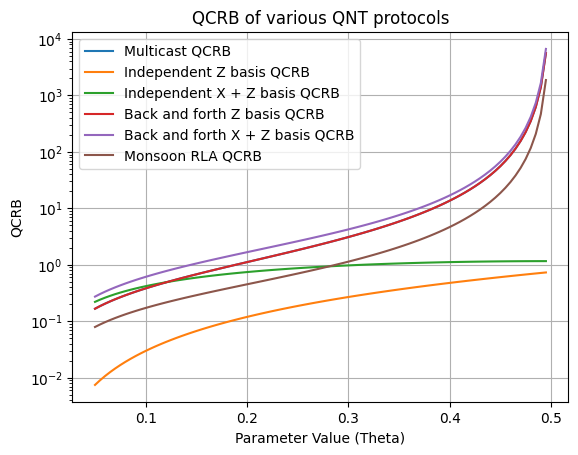

In [23]:
plt.plot(thetas,multicast_results, label='Multicast QCRB')
#plt.plot(thetas,rl_results, label='RL Agent QCRB')
plt.plot(thetas,iez_results, label='Independent Z basis QCRB')
plt.plot(thetas,iexz_results, label='Independent X + Z basis QCRB')
plt.plot(thetas,bfz_results, label='Back and forth Z basis QCRB')
plt.plot(thetas,bfxz_results, label='Back and forth X + Z basis QCRB')
plt.plot(thetas,monsoon_results, label='Monsoon RLA QCRB')




plt.xlabel('Parameter Value (Theta)')
plt.ylabel('QCRB')
plt.title('QCRB of various QNT protocols')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

## Simulate Protocols on Network

Up until now no measurements have been made. The RLA was trained to maximize the QFIM, which is a purely theoretical value. This next section discovers how well the protocols perform when simulated on the network with actual measurements. This involves generating measurement outcomes based on the qubit paths and calculating the estimation accuracy of each protocol using a least squares estimator.

In [24]:
def simulate_network(state,thetas,iterations):
    path_lists=[]
    for i in range(3):
        path_list=nodes_to_paths(state[i][:])
        path_lists.append(path_list)


    int_list_0 = [int(x) for x in path_lists[0]]
    int_list_1 = [int(x) for x in path_lists[1]]
    int_list_2 = [int(x) for x in path_lists[2]]
    
    e1=symbolic_sum_of_products(int_list_0)
    e2=symbolic_sum_of_products(int_list_1)
    e3=symbolic_sum_of_products(int_list_2)


    eigen_vals=equations_to_eigen_vals([e1,e2,e3])

    symbols_list = symbols('p1 p2 p3')      

    n = len(symbols_list)

    subs_dict = {symbols('p1_hat'): 1 - symbols('p1'),
                 symbols('p2_hat'): 1 - symbols('p2'),
                 symbols('p3_hat'): 1 - symbols('p3')}
    
    lambdas_sub = [lam.subs(subs_dict) for lam in eigen_vals]

    t1,t2,t3=thetas

    theta_dict = {symbols('p1'): t1,
                    symbols('p2'): t2,
                    symbols('p3'): t3} # Substitution dictionary for theta values
    
    lambdas_num = [lam.subs(theta_dict) for lam in lambdas_sub]

    # for lam in lambdas_num:
    #     print(lam)
    # print(sum(lambdas_num))
    # Simulate proportions

    proportions = [0, 0, 0, 0, 0, 0, 0, 0]  # Initialize counts for each eigenvalue

    for _ in range(iterations):
        rand_val = random.uniform(0, 1)
        if rand_val < lambdas_num[0]:
            proportions[0] += 1
        elif rand_val < sum(lambdas_num[:2]):
            proportions[1] += 1
        elif rand_val < sum(lambdas_num[:3]):
            proportions[2] += 1
        elif rand_val < sum(lambdas_num[:4]):
            proportions[3] += 1
        elif rand_val < sum(lambdas_num[:5]):
            proportions[4] += 1
        elif rand_val < sum(lambdas_num[:6]):
            proportions[5] += 1
        elif rand_val < sum(lambdas_num[:7]):
            proportions[6] += 1
        else:
            proportions[7] += 1



    proportions = [count / iterations for count in proportions]  # Convert counts to proportions
    return proportions            

states=[[3,2,1,0,0,0,0,0,0,0],
        [1,2,3,0,0,0,0,0,0,0],
        [2,1,3,0,0,0,0,0,0,0]]
thetas=[.5,.5,.5]

proportions=simulate_network(states,thetas,1000)
print(proportions)

[0.129, 0.123, 0.112, 0.138, 0.12, 0.149, 0.123, 0.106]


## Create Qubit Mover Estimator

This is a notebook to create an estimator for an arbitrary qubit mover distribution protocol. The estimator will receive as input the measurements of the qubit in the computational bases and then output an estimate of the thetas of the qubit mover distribution protocol.

This works in the reverse way of the qubit mover density matrix algorithm. Essentially what we are given is the density matrix, in the form of the likelihood values. From here we want to determine a possible set of thetas that could have generated this density matrix. Additionally we are given the protocol, which allows us to recreate the thetas symbolically. 

This then becomes a system of 4 equations and 4 unknowns.

In [25]:
model = PPO.load("agents/ppo_qubit_mover_agent_continued.zip", env=env)

# Evaluate the agent for one episode
obs, info = env.reset()

# Custom observation for testing

obs, info = env.reset()

done = False
total_reward = 0

while not done:
    action, _states = model.predict(obs, deterministic=False)
    obs, reward_vals, done, truncated, info = env.step(action)
    total_reward += reward_vals

state=obs[:-3].reshape(3,10)
thetas=obs[-3:]

proportions=simulate_network(state,thetas,1000)


def estimator(state,proportions,guess=[0.25,0.25,0.25]):
    path_lists=[]
    for i in range(3):
        path_list=nodes_to_paths(state[i][:])
        path_lists.append(path_list)


    int_list_0 = [int(x) for x in path_lists[0]]
    int_list_1 = [int(x) for x in path_lists[1]]
    int_list_2 = [int(x) for x in path_lists[2]]
    
    e1=symbolic_sum_of_products(int_list_0)
    e2=symbolic_sum_of_products(int_list_1)
    e3=symbolic_sum_of_products(int_list_2)


    eigen_vals=equations_to_eigen_vals([e1,e2,e3])

    symbols_list = symbols('p1 p2 p3')      

    n = len(symbols_list)


    subs_dict = {symbols('p1_hat'): 1 - symbols('p1'),
                 symbols('p2_hat'): 1 - symbols('p2'),
                 symbols('p3_hat'): 1 - symbols('p3')}
    
    lambdas_sub = [lam.subs(subs_dict) for lam in eigen_vals]

    eqs = [lhs - rhs for lhs, rhs in zip(lambdas_sub, proportions)]

    eq_funcs = [lambdify(symbols_list, eq, 'numpy') for eq in eqs] # Converts sympy expressions to numerical functions

    # Define the function for root finding
    def equations_numeric(x):
        return np.array([f(*x) for f in eq_funcs])

    # Initial guess
    

    # Find the root
    sol = least_squares(equations_numeric, guess,bounds=([0,0,0],[0.5,0.5,0.5]))
    return(sol.x)  # The solution


theta_hats=estimator(state,proportions)
print("Thetas: ",thetas)
print("Theta Estimates: ",theta_hats)

mean_squared_error = np.mean((np.array(thetas) - np.array(theta_hats))**2)
print("Mean Squared Error:", mean_squared_error)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Thetas:  [0.18346593 0.47961256 0.43543705]
Theta Estimates:  [0.31983172 0.5        0.32752742]
Mean Squared Error: 0.010218588808407264
Thetas:  [0.18346593 0.47961256 0.43543705]
Theta Estimates:  [0.31983172 0.5        0.32752742]
Mean Squared Error: 0.010218588808407264


### Track and Plot Results

In [ ]:
errors=[]
thetas=np.arange(0.05,0.5,0.01)
for i in range(len(thetas)):
    temp_errors=[]
    for j in range(10):
        model = PPO.load("agents/ppo_qubit_mover_agent_continued.zip", env=env)

        # Evaluate the agent for one episode
        obs, info = env.reset()

        # Custom observation for testing

        obs, info = env.reset()
        env.thetas=[thetas[i],thetas[i],thetas[i]]

        done = False
        total_reward = 0

        while not done:
            action, _states = model.predict(obs, deterministic=False)
            obs, reward_vals, done, truncated, info = env.step(action)
            total_reward += reward_vals

        state=obs[:-3].reshape(3,10)
        theta_vals=obs[-3:]

        proportions=simulate_network(state,theta_vals,1000)
        theta_hats=estimator(state,proportions)

        mean_squared_error = np.mean((np.array(theta_vals) - np.array(theta_hats))**2)
        temp_errors.append(mean_squared_error)
    errors.append(np.mean(temp_errors))


errors2=[]
thetas=np.arange(0.05,0.5,0.01)
for i in range(len(thetas)):
    temp_errors=[]
    for j in range(10):
        model = PPO.load("agents/monsoon2.zip", env=env)

        # Evaluate the agent for one episode
        obs, info = env.reset()

        # Custom observation for testing

        obs, info = env.reset()
        env.thetas=[thetas[i],thetas[i],thetas[i]]

        done = False
        total_reward = 0

        while not done:
            action, _states = model.predict(obs, deterministic=False)
            obs, reward_vals, done, truncated, info = env.step(action)
            total_reward += reward_vals

        state=obs[:-3].reshape(3,10)
        theta_vals=obs[-3:]

        proportions=simulate_network(state,theta_vals,1000)
        theta_hats=estimator(state,proportions)

        mean_squared_error = np.mean((np.array(theta_vals) - np.array(theta_hats))**2)
        temp_errors.append(mean_squared_error)
    errors2.append(np.mean(temp_errors))





    

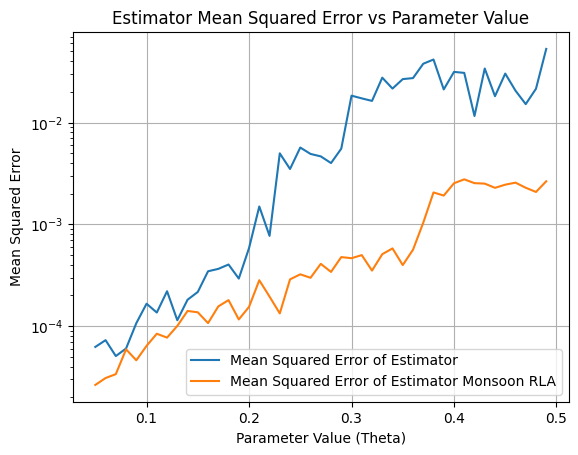

In [ ]:
## Visualize the Results
plt.plot(thetas,errors, label='Mean Squared Error of Estimator')
plt.plot(thetas,errors2, label='Mean Squared Error of Estimator Monsoon RLA')
plt.xlabel('Parameter Value (Theta)')
plt.ylabel('Mean Squared Error')
plt.title('Estimator Mean Squared Error vs Parameter Value')
plt.legend()



plt.grid(True)
plt.yscale('log')
plt.show()

In [ ]:
errors=[]
thetas=0.42
iterations=np.arange(200,2000,200)
for i in range(len(iterations)):
    temp_errors=[]
    for j in range(50):
        model = PPO.load("agents/ppo_qubit_mover_agent_continued.zip", env=env)

        # Evaluate the agent for one episode
        obs, info = env.reset()

        # Custom observation for testing

        obs, info = env.reset()
        env.thetas=[thetas,thetas,thetas]

        done = False
        total_reward = 0

        while not done:
            action, _states = model.predict(obs, deterministic=False)
            obs, reward_vals, done, truncated, info = env.step(action)
            total_reward += reward_vals

        state=obs[:-3].reshape(3,10)
        theta_vals=obs[-3:]

        proportions=simulate_network(state,theta_vals,iterations[i])
        theta_hats=estimator(state,proportions)

        mean_squared_error = np.mean((np.array(theta_vals) - np.array(theta_hats))**2)
        temp_errors.append(mean_squared_error)
    errors.append(np.mean(temp_errors))






    

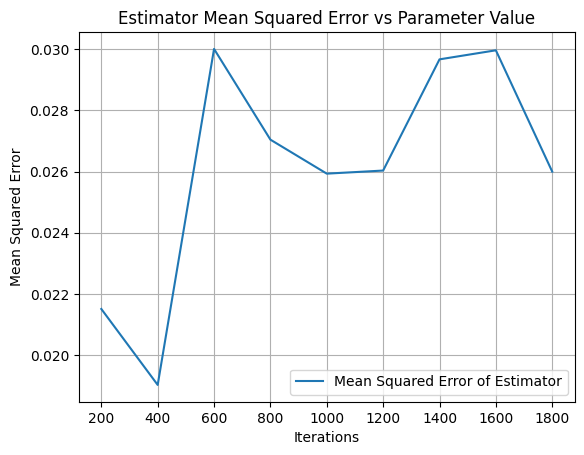

In [ ]:
## Visualize the Results
plt.plot(iterations,errors, label='Mean Squared Error of Estimator')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Estimator Mean Squared Error vs Parameter Value')
plt.legend()
plt.grid(True)

plt.show()

## Create Other Protocol Estimators

### Multicast

In [27]:
def multicast_proportions(thetas,iterations):

    t1,t2,t3=thetas



    symbols_list = symbols('p1 p2 p3')
    p1 , p2, p3 = symbols_list      

    hat_symbols_list = symbols('p1_hat p2_hat p3_hat')
    p1_hat, p2_hat, p3_hat = hat_symbols_list


    ev1=p1_hat*p2_hat*p3_hat + p1*p2*p3

    ev2=p1_hat * p3 * p2_hat + p1 * p3_hat * p2

    ev3=p1_hat * p2 * p3_hat + p1 * p2_hat * p3

    ev4= p3_hat * p1 * p2_hat + p2 * p1_hat * p3

    eigen_vals = [ev1,ev2,ev3,ev4]

    subs_dict = {symbols('p1_hat'): 1 - symbols('p1'),
                 symbols('p2_hat'): 1 - symbols('p2'),
                 symbols('p3_hat'): 1 - symbols('p3')}
    
    lambdas_sub = [lam.subs(subs_dict) for lam in eigen_vals]





    theta_dict = {symbols('p1'): t1,
                    symbols('p2'): t2,
                    symbols('p3'): t3} # Substitution dictionary for theta values
    
    lambdas_num = [lam.subs(theta_dict) for lam in lambdas_sub]

    # for lam in lambdas_num:
    #     print(lam)
    # print(sum(lambdas_num))
    # Simulate proportions

    proportions = [0, 0, 0, 0]  # Initialize counts for each eigenvalue

    for _ in range(iterations):
        rand_val = random.uniform(0, 1)
        if rand_val < lambdas_num[0]:
            proportions[0] += 1
        elif rand_val < sum(lambdas_num[:2]):
            proportions[1] += 1
        elif rand_val < sum(lambdas_num[:3]):
            proportions[2] += 1
        else:
            proportions[3] += 1



    proportions = [count / iterations for count in proportions]  # Convert counts to proportions
    return proportions 


In [28]:
def multicast_estimator(proportions):

    symbols_list = symbols('p1 p2 p3')
    p1 , p2, p3 = symbols_list      

    hat_symbols_list = symbols('p1_hat p2_hat p3_hat')
    p1_hat, p2_hat, p3_hat = hat_symbols_list


    ev1=p1_hat*p2_hat*p3_hat + p1*p2*p3

    ev2=p1_hat * p3 * p2_hat + p1 * p3_hat * p2

    ev3=p1_hat * p2 * p3_hat + p1 * p2_hat * p3

    ev4= p3_hat * p1 * p2_hat + p2 * p1_hat * p3

    eigen_vals = [ev1,ev2,ev3,ev4]

    subs_dict = {symbols('p1_hat'): 1 - symbols('p1'),
                 symbols('p2_hat'): 1 - symbols('p2'),
                 symbols('p3_hat'): 1 - symbols('p3')}
    
    lambdas_sub = [lam.subs(subs_dict) for lam in eigen_vals]

    eqs = [lhs - rhs for lhs, rhs in zip(lambdas_sub, proportions)]

    eq_funcs = [lambdify(symbols_list, eq, 'numpy') for eq in eqs] # Converts sympy expressions to numerical functions

    # Define the function for root finding
    def equations_numeric(x):
        return np.array([f(*x) for f in eq_funcs])

    # Initial guess
    x0 = [0.25,0.25,0.25]

    # Find the root
    sol = least_squares(equations_numeric, x0,bounds=([0,0,0],[0.5,0.5,0.5]))
    return(sol.x)  # The solution

thetas=np.random.uniform(0.05, 0.5, 3).tolist()
proportions=multicast_proportions(thetas,1000)

theta_hats=multicast_estimator(proportions)
print("Thetas: ",thetas)
print("Theta Estimates: ",theta_hats)
print("Proportions:",proportions)

Thetas:  [0.24046220490720932, 0.2335586274353677, 0.05265457297929841]
Theta Estimates:  [0.23680361 0.22264057 0.07636198]
Proportions: [0.552, 0.094, 0.171, 0.183]


### Independent Encoding Z basis

In [29]:
def iez_proportions(thetas,iterations):

    t1,t2,t3=thetas



    symbols_list = symbols('p1 p2 p3')
    p1 , p2, p3 = symbols_list      

    hat_symbols_list = symbols('p1_hat p2_hat p3_hat')
    p1_hat, p2_hat, p3_hat = hat_symbols_list


    ev1=p1*p2*p3
    ev2=p1*p2*p3_hat
    ev3=p1*p2_hat*p3
    ev4=p1*p2_hat*p3_hat
    
    ev5=p1_hat*p2*p3
    ev6=p1_hat*p2*p3_hat
    ev7=p1_hat*p2_hat*p3
    ev8=p1_hat*p2_hat*p3_hat

    eigen_vals = [ev1,ev2,ev3,ev4,ev5,ev6,ev7,ev8]

    subs_dict = {symbols('p1_hat'): 1 - symbols('p1'),
                 symbols('p2_hat'): 1 - symbols('p2'),
                 symbols('p3_hat'): 1 - symbols('p3')}
    
    lambdas_sub = [lam.subs(subs_dict) for lam in eigen_vals]





    theta_dict = {symbols('p1'): t1,
                    symbols('p2'): t2,
                    symbols('p3'): t3} # Substitution dictionary for theta values
    
    lambdas_num = [lam.subs(theta_dict) for lam in lambdas_sub]

    # for lam in lambdas_num:
    #     print(lam)
    # print(sum(lambdas_num))
    # Simulate proportions

    proportions = [0, 0, 0, 0,0,0,0,0]  # Initialize counts for each eigenvalue

    for _ in range(iterations):
        rand_val = random.uniform(0, 1)
        if rand_val < lambdas_num[0]:
            proportions[0] += 1
        elif rand_val < sum(lambdas_num[:2]):
            proportions[1] += 1
        elif rand_val < sum(lambdas_num[:3]):
            proportions[2] += 1
        elif rand_val < sum(lambdas_num[:4]):
            proportions[3] += 1
        elif rand_val < sum(lambdas_num[:5]):
            proportions[4] += 1
        elif rand_val < sum(lambdas_num[:6]):
            proportions[5] += 1
        elif rand_val < sum(lambdas_num[:7]):
            proportions[6] += 1
        else:
            proportions[7] += 1



    proportions = [count / iterations for count in proportions]  # Convert counts to proportions
    return proportions 


In [30]:
def iez_estimator(proportions):

    symbols_list = symbols('p1 p2 p3')
    p1 , p2, p3 = symbols_list      

    hat_symbols_list = symbols('p1_hat p2_hat p3_hat')
    p1_hat, p2_hat, p3_hat = hat_symbols_list


    ev1=p1*p2*p3
    ev2=p1*p2*p3_hat
    ev3=p1*p2_hat*p3
    ev4=p1*p2_hat*p3_hat
    
    ev5=p1_hat*p2*p3
    ev6=p1_hat*p2*p3_hat
    ev7=p1_hat*p2_hat*p3
    ev8=p1_hat*p2_hat*p3_hat

    eigen_vals = [ev1,ev2,ev3,ev4,ev5,ev6,ev7,ev8]


    subs_dict = {symbols('p1_hat'): 1 - symbols('p1'),
                 symbols('p2_hat'): 1 - symbols('p2'),
                 symbols('p3_hat'): 1 - symbols('p3')}
    
    lambdas_sub = [lam.subs(subs_dict) for lam in eigen_vals]

    eqs = [lhs - rhs for lhs, rhs in zip(lambdas_sub, proportions)]

    eq_funcs = [lambdify(symbols_list, eq, 'numpy') for eq in eqs] # Converts sympy expressions to numerical functions

    # Define the function for root finding
    def equations_numeric(x):
        return np.array([f(*x) for f in eq_funcs])

    # Initial guess
    x0 = [0.25,0.25,0.25]

    # Find the root
    sol = least_squares(equations_numeric, x0,bounds=([0,0,0],[0.5,0.5,0.5]))
    return(sol.x)  # The solution

thetas=np.random.uniform(0.05, 0.5, 3).tolist()
proportions=iez_proportions(thetas,1000)

theta_hats=iez_estimator(proportions)
print("Thetas: ",thetas)
print("Theta Estimates: ",theta_hats)
print("Proportions:",proportions)

Thetas:  [0.3124091315568309, 0.13050044673334546, 0.3120544866708193]
Theta Estimates:  [0.31896042 0.13443879 0.32621487]
Proportions: [0.017, 0.031, 0.1, 0.18, 0.022, 0.063, 0.188, 0.399]


### Back and forth Z basis

In [31]:
def bfz_proportions(thetas,iterations):

    t1,t2,t3=thetas



    symbols_list = symbols('p1 p2 p3')
    p1 , p2, p3 = symbols_list      

    hat_symbols_list = symbols('p1_hat p2_hat p3_hat')
    p1_hat, p2_hat, p3_hat = hat_symbols_list


    ev1=p1*p2*p3 + p1_hat*p2_hat*p3_hat
    ev2=p1*p2*p3_hat + p1_hat*p2_hat*p3
    ev3=p1*p2_hat*p3 + p1_hat*p2*p3_hat
    ev4=p1*p2_hat*p3_hat + p1_hat*p2*p3
    
    ev5=p1_hat*p2*p3 + p1*p2_hat*p3_hat
    ev6=p1_hat*p2*p3_hat + p1*p2_hat*p3
    ev7=p1_hat*p2_hat*p3 + p1*p2*p3_hat
    ev8=p1_hat*p2_hat*p3_hat + p1*p2*p3

    eigen_vals = [ev1,ev2,ev3,ev4,ev5,ev6,ev7,ev8]

    subs_dict = {symbols('p1_hat'): 1 - symbols('p1'),
                 symbols('p2_hat'): 1 - symbols('p2'),
                 symbols('p3_hat'): 1 - symbols('p3')}
    
    lambdas_sub = [lam.subs(subs_dict) for lam in eigen_vals]





    theta_dict = {symbols('p1'): t1,
                    symbols('p2'): t2,
                    symbols('p3'): t3} # Substitution dictionary for theta values
    
    lambdas_num = [lam.subs(theta_dict) for lam in lambdas_sub]

    # for lam in lambdas_num:
    #     print(lam)
    # print(sum(lambdas_num))
    # Simulate proportions

    proportions = [0, 0, 0, 0,0,0,0,0]  # Initialize counts for each eigenvalue

    for _ in range(iterations):
        rand_val = random.uniform(0, 1)
        if rand_val < lambdas_num[0]:
            proportions[0] += 1
        elif rand_val < sum(lambdas_num[:2]):
            proportions[1] += 1
        elif rand_val < sum(lambdas_num[:3]):
            proportions[2] += 1
        elif rand_val < sum(lambdas_num[:4]):
            proportions[3] += 1
        elif rand_val < sum(lambdas_num[:5]):
            proportions[4] += 1
        elif rand_val < sum(lambdas_num[:6]):
            proportions[5] += 1
        elif rand_val < sum(lambdas_num[:7]):
            proportions[6] += 1
        else:
            proportions[7] += 1



    proportions = [count / iterations for count in proportions]  # Convert counts to proportions
    return proportions 


In [32]:
def bfz_estimator(proportions):

    symbols_list = symbols('p1 p2 p3')
    p1 , p2, p3 = symbols_list      

    hat_symbols_list = symbols('p1_hat p2_hat p3_hat')
    p1_hat, p2_hat, p3_hat = hat_symbols_list


    ev1=p1*p2*p3 + p1_hat*p2_hat*p3_hat
    ev2=p1*p2*p3_hat + p1_hat*p2_hat*p3
    ev3=p1*p2_hat*p3 + p1_hat*p2*p3_hat
    ev4=p1*p2_hat*p3_hat + p1_hat*p2*p3
    
    ev5=p1_hat*p2*p3 + p1*p2_hat*p3_hat
    ev6=p1_hat*p2*p3_hat + p1*p2_hat*p3
    ev7=p1_hat*p2_hat*p3 + p1*p2*p3_hat
    ev8=p1_hat*p2_hat*p3_hat + p1*p2*p3

    eigen_vals = [ev1,ev2,ev3,ev4,ev5,ev6,ev7,ev8]


    subs_dict = {symbols('p1_hat'): 1 - symbols('p1'),
                 symbols('p2_hat'): 1 - symbols('p2'),
                 symbols('p3_hat'): 1 - symbols('p3')}
    
    lambdas_sub = [lam.subs(subs_dict) for lam in eigen_vals]

    eqs = [lhs - rhs for lhs, rhs in zip(lambdas_sub, proportions)]

    eq_funcs = [lambdify(symbols_list, eq, 'numpy') for eq in eqs] # Converts sympy expressions to numerical functions

    # Define the function for root finding
    def equations_numeric(x):
        return np.array([f(*x) for f in eq_funcs])

    # Initial guess
    x0 = [0.25,0.25,0.25]

    # Find the root
    sol = least_squares(equations_numeric, x0,bounds=([0,0,0],[0.5,0.5,0.5]))
    return(sol.x)  # The solution

thetas=np.random.uniform(0.05, 0.5, 3).tolist()
proportions=iez_proportions(thetas,1000)

theta_hats=iez_estimator(proportions)
print("Thetas: ",thetas)
print("Theta Estimates: ",theta_hats)
print("Proportions:",proportions)

Thetas:  [0.24172263575401684, 0.12874691077798683, 0.3244319547649821]
Theta Estimates:  [0.2443526  0.12745121 0.32083275]
Proportions: [0.008, 0.021, 0.06, 0.15, 0.033, 0.066, 0.215, 0.447]


## Create Iterative Qubit Mover Estimator

In [33]:
def get_state(thetas):
    model = PPO.load("agents/monsoon2.zip", env=env)

    # Evaluate the agent for one episode
    obs, info = env.reset()

    # Custom observation for testing

    obs, info = env.reset()
    env.thetas=thetas

    done = False
    total_reward = 0

    while not done:
        action, _states = model.predict(obs, deterministic=False)
        obs, reward_vals, done, truncated, info = env.step(action)
        total_reward += reward_vals

    state=obs[:-3].reshape(3,10)
    
    return state
thetas=[0.45,0.01,0.45]
state=get_state(thetas)
print(state)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 3. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [47]:
def iterative_estimation(thetas,iterations,guess=[0.25,0.25,0.25],shots=1000):
    for i in range(iterations):
        states=get_state(guess)
        proportions=simulate_network(states,thetas,shots)
        theta_hats=estimator(states,proportions,guess)
        guess=theta_hats
    return guess


## Benchmark Estimators

### Error vs Theta

In [ ]:
errors=[]
multicast_errors=[]
iez_errors=[]
bfz_errors=[]
monsoon_errors=[]
iterative_errors=[]

thetas=np.arange(0.05,0.5,0.01)
for i in range(len(thetas)):
    temp_errors=[]
    temp_mc=[]
    temp_iez=[]
    temp_bfz=[]
    temp_errors2=[]

    temp_errors_iterative=[]

    


    # Only the RL agent needs to be iterated twice
    for j in range(100):

        ######################################
        ## Previously Determined Protocols ###
        ######################################

        mc_proportions=multicast_proportions([thetas[i],thetas[i],thetas[i]],1000)
        multicast_thetas=multicast_estimator(mc_proportions)
        mc_mse = np.mean((np.array([thetas[i],thetas[i],thetas[i]] ) - np.array(multicast_thetas))**2)
        temp_mc.append(np.sqrt(mc_mse))

        iez_p=iez_proportions([thetas[i],thetas[i],thetas[i]],1000)
        iez_thetas=iez_estimator(iez_p)
        iez_mse = np.mean((np.array([thetas[i],thetas[i],thetas[i]] ) - np.array(iez_thetas))**2)
        temp_iez.append(np.sqrt(iez_mse))

        bf_p=bfz_proportions([thetas[i],thetas[i],thetas[i]],1000)
        bf_thetas=bfz_estimator(bf_p)
        bf_mse = np.mean((np.array([thetas[i],thetas[i],thetas[i]] ) - np.array(bf_thetas))**2)
        temp_bfz.append(np.sqrt(bf_mse))



        ######################################
        ##      Monsoon RLA                ###
        ######################################

        model = PPO.load("agents/monsoon2.zip", env=env)

        # Evaluate the agent for one episode
        obs, info = env.reset()

        # Custom observation for testing

        obs, info = env.reset()
        env.thetas=[thetas[i],thetas[i],thetas[i]]

        done = False
        total_reward = 0

        while not done:
            action, _states = model.predict(obs, deterministic=False)
            obs, reward_vals, done, truncated, info = env.step(action)
            total_reward += reward_vals

        state=obs[:-3].reshape(3,10)
        theta_vals=obs[-3:]

        proportions=simulate_network(state,theta_vals,1000)
        theta_hats=estimator(state,proportions)

        mean_squared_error = np.mean((np.array(theta_vals) - np.array(theta_hats))**2)
        temp_errors2.append(np.sqrt(mean_squared_error))



        ######################################
        ##      Iterative Estimation       ###
        ######################################
        iterative_thetas=iterative_estimation([thetas[i],thetas[i],thetas[i]],10)

        iterative_mse = np.mean((np.array(theta_vals ) - np.array(iterative_thetas))**2)
        temp_errors_iterative.append(np.sqrt(iterative_mse))


    multicast_errors.append(np.mean(temp_mc))
    iez_errors.append(np.mean(temp_iez))
    bfz_errors.append(np.mean(temp_bfz))
    monsoon_errors.append(np.mean(temp_errors2))
    iterative_errors.append(np.mean(temp_errors_iterative))


# Create a data frame
results_dict = {
    'theta': thetas,
    'Monsoon RLA MSE': monsoon_errors,
    'Multicast MSE': multicast_errors,
    'Independent Z basis MSE': iez_errors,
    'Back and forth Z basis MSE': bfz_errors,
    'Iterative Estimation MSE': iterative_errors
}

# Create a DataFrame
df = pd.DataFrame(results_dict)


# Save to CSV
df.to_csv('data/error_vs_theta.csv', index=False)


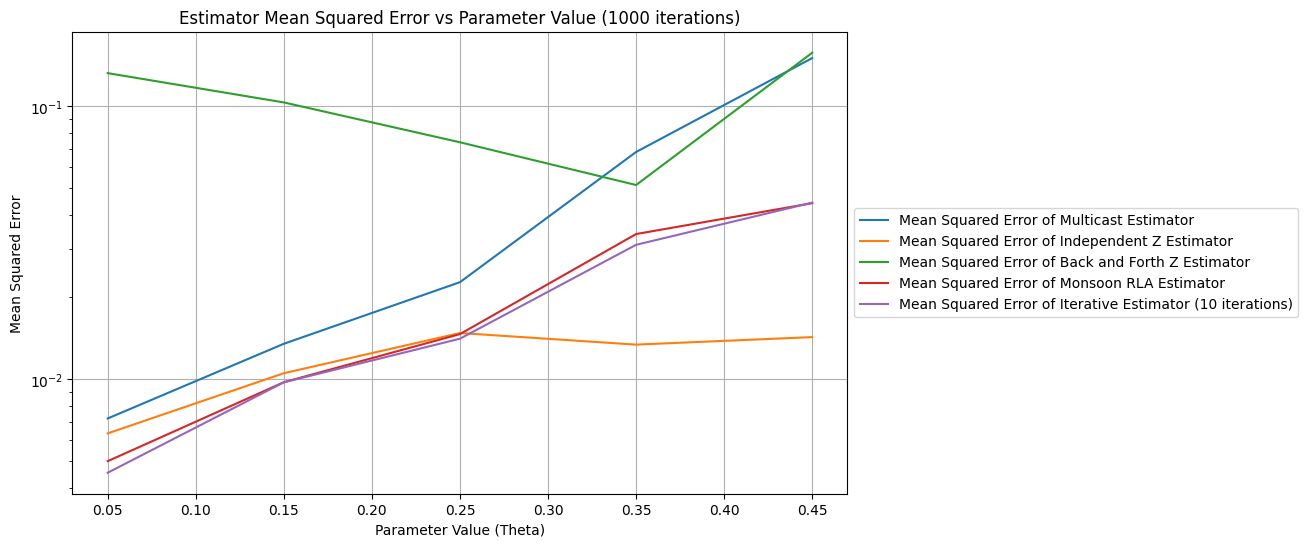

In [37]:
plt.figure(figsize=(10, 6))  # Make the plot larger

plt.plot(thetas,multicast_errors, label='Mean Squared Error of Multicast Estimator')
plt.plot(thetas,iez_errors, label='Mean Squared Error of Independent Z Estimator')
plt.plot(thetas,bfz_errors, label='Mean Squared Error of Back and Forth Z Estimator')
#plt.plot(thetas,errors, label='Mean Squared Error of RL Agent Estimator')
plt.plot(thetas,monsoon_errors, label='Mean Squared Error of Monsoon RLA Estimator')
plt.plot(thetas,iterative_errors, label='Mean Squared Error of Iterative Estimator (10 iterations)')
plt.xlabel('Parameter Value (Theta)')
plt.ylabel('Mean Squared Error')
plt.title('Estimator Mean Squared Error vs Parameter Value (1000 iterations)')
plt.grid(True)
plt.yscale('log')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside

plt.show()

### Error vs Shots

In [ ]:
errors=[]
multicast_errors=[]
iez_errors=[]
bfz_errors=[]
monsoon_errors=[]
iterative_errors=[]

iterations=np.arange(200,2000,50)
thetas=[0.30,0.30,0.30]


for i in range(len(iterations)):
    temp_errors=[]
    temp_mc=[]
    temp_iez=[]
    temp_bfz=[]
    temp_errors2=[]

    temp_errors_iterative=[]

    


    # Only the RL agent needs to be iterated twice
    for j in range(100):

        ######################################
        ## Previously Determined Protocols ###
        ######################################

        mc_proportions=multicast_proportions([thetas[0],thetas[0],thetas[0]],iterations[i])
        multicast_thetas=multicast_estimator(mc_proportions)
        mc_mse = np.mean((np.array([thetas[0],thetas[0],thetas[0]] ) - np.array(multicast_thetas))**2)
        temp_mc.append(np.sqrt(mc_mse))

        iez_p=iez_proportions([thetas[0],thetas[0],thetas[0]],iterations[i])
        iez_thetas=iez_estimator(iez_p)
        iez_mse = np.mean((np.array([thetas[0],thetas[0],thetas[0]] ) - np.array(iez_thetas))**2)
        temp_iez.append(np.sqrt(iez_mse))

        bf_p=bfz_proportions([thetas[0],thetas[0],thetas[0]],iterations[i])
        bf_thetas=bfz_estimator(bf_p)
        bf_mse = np.mean((np.array([thetas[0],thetas[0],thetas[0]] ) - np.array(bf_thetas))**2)
        temp_bfz.append(np.sqrt(bf_mse))



        ######################################
        ##      Monsoon RLA                ###
        ######################################

        model = PPO.load("agents/monsoon2.zip", env=env)

        # Evaluate the agent for one episode
        obs, info = env.reset()

        # Custom observation for testing

        obs, info = env.reset()
        env.thetas=[thetas[0],thetas[0],thetas[0]]

        done = False
        total_reward = 0

        while not done:
            action, _states = model.predict(obs, deterministic=False)
            obs, reward_vals, done, truncated, info = env.step(action)
            total_reward += reward_vals

        state=obs[:-3].reshape(3,10)
        theta_vals=obs[-3:]

        proportions=simulate_network(state,theta_vals,iterations[i])
        theta_hats=estimator(state,proportions)

        mean_squared_error = np.mean((np.array(theta_vals) - np.array(theta_hats))**2)
        temp_errors2.append(np.sqrt(mean_squared_error))



        ######################################
        ##      Iterative Estimation       ###
        ######################################
        iterative_thetas=iterative_estimation([thetas[0],thetas[0],thetas[0]],10,shots=iterations[i])

        iterative_mse = np.mean((np.array(theta_vals ) - np.array(iterative_thetas))**2)
        temp_errors_iterative.append(np.sqrt(iterative_mse))


    multicast_errors.append(np.mean(temp_mc))
    iez_errors.append(np.mean(temp_iez))
    bfz_errors.append(np.mean(temp_bfz))
    monsoon_errors.append(np.mean(temp_errors2))
    iterative_errors.append(np.mean(temp_errors_iterative))


# Create a data frame
results_dict = {
    'iterations': iterations,
    'Monsoon RLA MSE': monsoon_errors,
    'Multicast MSE': multicast_errors,
    'Independent Z basis MSE': iez_errors,
    'Back and forth Z basis MSE': bfz_errors,
    'Iterative Estimation MSE': iterative_errors
}

# Create a DataFrame
df = pd.DataFrame(results_dict)


# Save to CSV
df.to_csv('data/error_vs_iterations.csv', index=False)


#### Plot the results

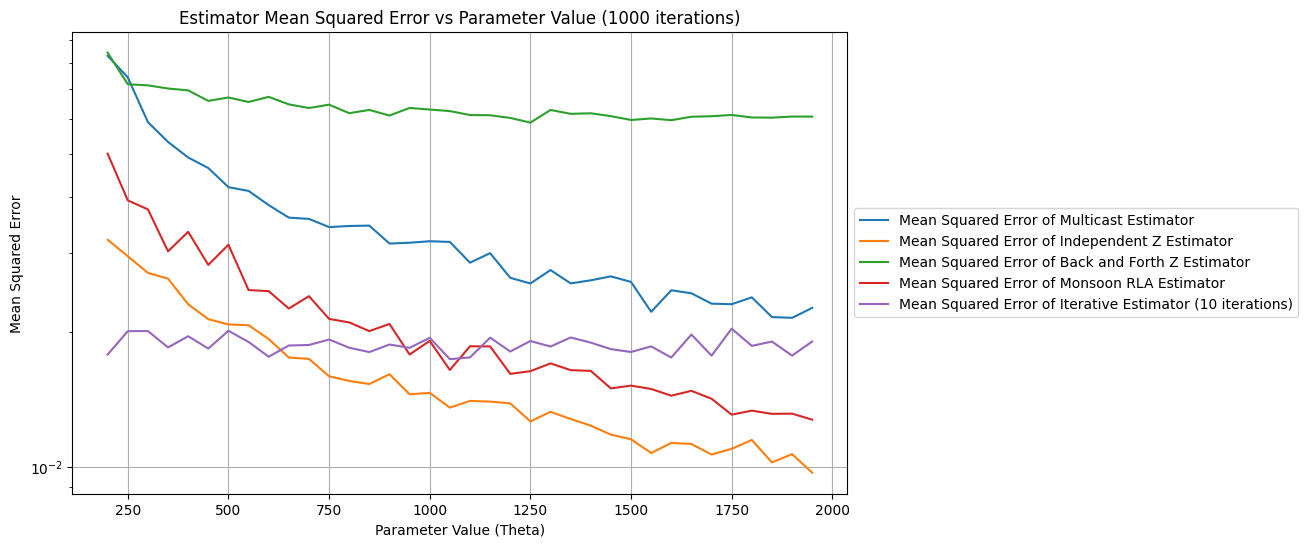

In [46]:
plt.figure(figsize=(10, 6))  # Make the plot larger

plt.plot(iterations,multicast_errors, label='Mean Squared Error of Multicast Estimator')
plt.plot(iterations,iez_errors, label='Mean Squared Error of Independent Z Estimator')
plt.plot(iterations,bfz_errors, label='Mean Squared Error of Back and Forth Z Estimator')
#plt.plot(thetas,errors, label='Mean Squared Error of RL Agent Estimator')
plt.plot(iterations,monsoon_errors, label='Mean Squared Error of Monsoon RLA Estimator')
plt.plot(iterations,iterative_errors, label='Mean Squared Error of Iterative Estimator (10 iterations)')
plt.xlabel('Parameter Value (Theta)')
plt.ylabel('Mean Squared Error')
plt.title('Estimator Mean Squared Error vs Parameter Value (1000 iterations)')
plt.grid(True)
plt.yscale('log')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside

plt.show()